<a href="https://colab.research.google.com/github/Francisco7788/Image-Captioning-ResNet-and-LSTM/blob/main/Projeto_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bibliotecas e carregamento do dataset

In [ ]:
!pip install wandb
!pip install torch torchvision gradio
!pip install --upgrade --force-reinstall nltk
!pip install datasets
!pip install optuna
!pip install kagglehub
!pip install transformers
pip install kagglehub

  Using cached nltk-3.9.1-py3-none-any.whl.metadata (2.9 kB)
  Using cached click-8.1.8-py3-none-any.whl.metadata (2.3 kB)
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached regex-2024.11.6-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (40 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
Using cached nltk-3.9.1-py3-none-any.whl (1.5 MB)
Using cached regex-2024.11.6-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (792 kB)
Using cached click-8.1.8-py3-none-any.whl (98 kB)
Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.67.1
    Uninstalling tqdm-4.67.1:
      Successfully uninstalled tqdm-4.67.1
  Attempting uninstall: regex
    Found existing installation: regex 2024.11.6
    Uninstalling regex-2024.11.6:
      Successfully uninstalled regex-2024.11.6
  Attempting uninstall: joblib
    Found

ERROR: Operation cancelled by user


In [ ]:
import nltk

# Baixar recursos necessários
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

Recursos do NLTK baixados com sucesso!


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
import os
import re
import csv
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from torchvision.models import ResNet50_Weights
from collections import Counter
from PIL import Image
import random
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
import datetime
import pytz
import wandb
import sklearn
from tqdm import tqdm

In [ ]:
wandb.login()

wandb: Currently logged in as: f7085201 (f7085201-deeplearning). Use `wandb login --relogin` to force relogin


True

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("eeshawn/flickr30k")
print("Path to dataset files:", path)

100%|██████████| 4.08G/4.08G [01:03<00:00, 69.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/eeshawn/flickr30k/versions/1


In [ ]:
ls "/root/.cache/kagglehub/datasets/eeshawn/flickr30k/versions/1"

captions.txt  flickr30k_images/


In [ ]:


# Configurações iniciais
EMBED_DIM = 256
HIDDEN_DIM = 512
LEARNING_RATE = 0.001
BATCH_SIZE = 32
EPOCHS = 20
MIN_WORD_FREQ = 1
SEED = 42
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_WORKERS = 8


# Configurações do wandb (opcional, para monitoramento)
wandb.init(project="Projeto", config={
    "embed_dim": EMBED_DIM,
    "hidden_dim": HIDDEN_DIM,
    "learning_rate": LEARNING_RATE,
    "batch_size": BATCH_SIZE,
    "epochs": EPOCHS,
    "min_word_freq": MIN_WORD_FREQ,
    "seed": SEED,
    "device": DEVICE,
    "num_workers": NUM_WORKERS
})


# Caminhos do dataset
DATASET_PATH = "/root/.cache/kagglehub/datasets/eeshawn/flickr30k/versions/1"
IMAGES_DIR = os.path.join(DATASET_PATH, "flickr30k_images")  # Caminho para as imagens
TOKENS_FILE = os.path.join(DATASET_PATH, "captions.txt")  # Caminho para o arquivo de captions

# Caminhos para salvar checkpoints e vocabulário
BEST_CHECKPOINT_PATH = "best_checkpoint.pth"  # Checkpoint w/ epoch, model, optimizer, best_val_loss
FINAL_MODEL_PATH = "final_model.pth"          # Final model weights only (saved at the end)
VOCAB_PATH = "vocab.pkl"                      # Where we save the vocabulary


# Semente para reprodutibilidade
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)


# Carregar os dados
data = pd.read_csv(TOKENS_FILE)
print(data.head())

       image_name  comment_number  \
0  1000092795.jpg               0   
1  1000092795.jpg               1   
2  1000092795.jpg               2   
3  1000092795.jpg               3   
4  1000092795.jpg               4   

                                             comment  
0  Two young guys with shaggy hair look at their ...  
1  Two young  White males are outside near many b...  
2   Two men in green shirts are standing in a yard .  
3       A man in a blue shirt standing in a garden .  
4            Two friends enjoy time spent together .  


Gera uma legenda para cada imagem

# classes e funções

In [ ]:
class Vocabulary:
    def __init__(self, freq_threshold):
        self.freq_threshold = freq_threshold
        # self.itos = {0: "<pad>", 1: "<start>", 2: "<end>", 3: "<unk>"}
        self.itos = {0: "pad", 1: "startofseq", 2: "endofseq", 3: "unk"}
        self.stoi = {v: k for k, v in self.itos.items()}
        self.index = 4

    def __len__(self):
        return len(self.itos)

    def tokenizer(self, text):
        text = text.lower()
        tokens = re.findall(r"\w+", text)
        return tokens

    def build_vocabulary(self, sentence_list):
        frequencies = Counter()
        for sentence in sentence_list:
            tokens = self.tokenizer(sentence)
            frequencies.update(tokens)

        for word, freq in frequencies.items():
            if freq >= self.freq_threshold:
                self.stoi[word] = self.index
                self.itos[self.index] = word
                self.index += 1

    def numericalize(self, text):
        tokens = self.tokenizer(text)
        numericalized = []
        for token in tokens:
            if token in self.stoi:
                numericalized.append(self.stoi[token])
            else:
                numericalized.append(self.stoi["<unk>"])
        return numericalized

In [ ]:

def parse_flickr_tokens(csv_file):
    """
    Lê um arquivo CSV com colunas 'image_name' e 'comment' e retorna um dicionário:
    {image_filename: [captions]}
    """
    imgid2captions = {}
    captions_df = pd.read_csv(csv_file)

    for image_name, group in captions_df.groupby('image_name'):
        imgid2captions[image_name] = group['comment'].tolist()

    return imgid2captions


class FlickrDataset(Dataset):
    def __init__(self, imgid2captions, vocab, transform=None):
        self.imgid2captions = []
        self.transform = transform
        self.vocab = vocab

        # Flatten each (img_id, [cap1, cap2, ...]) into multiple examples
        for img_id, caps in imgid2captions.items():
            for c in caps:
                self.imgid2captions.append((img_id, c))

    def __len__(self):
        return len(self.imgid2captions)

    def __getitem__(self, idx):
        img_id, caption = self.imgid2captions[idx]
        # print('CAPTION START...', caption, 'CAPTION END\n')
        img_path = os.path.join(IMAGES_DIR, img_id)

        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        # with open('val_file.txt', 'a') as f:
        #     f.writelines(f"{img_path}: {caption}\n")

        # Numericalize caption
        # numerical_caption = [self.vocab.stoi["<start>"]]
        numerical_caption = [self.vocab.stoi["startofseq"]]
        numerical_caption += self.vocab.numericalize(caption)
        numerical_caption.append(self.vocab.stoi["endofseq"])

        return image, torch.tensor(numerical_caption, dtype=torch.long)

In [ ]:
def collate_fn(batch):
    batch.sort(key=lambda x: len(x[1]), reverse=True)
    images = [item[0] for item in batch]
    captions = [item[1] for item in batch]
    lengths = [len(cap) for cap in captions]
    max_len = max(lengths)

    padded_captions = torch.zeros(len(captions), max_len, dtype=torch.long)
    for i, cap in enumerate(captions):
        end = lengths[i]
        padded_captions[i, :end] = cap[:end]

    images = torch.stack(images, dim=0)
    return images, padded_captions, lengths

In [ ]:
class ResNetEncoder(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        resnet = models.resnet50(weights=ResNet50_Weights.DEFAULT)
        for param in resnet.parameters():
            param.requires_grad = True
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)

        self.fc = nn.Linear(resnet.fc.in_features, embed_dim)
        self.batch_norm = nn.BatchNorm1d(embed_dim, momentum=0.01)
        self.relu = nn.ReLU()  # Adicionando ReLU

    def forward(self, images):
        with torch.no_grad():
            features = self.resnet(images)  # (batch_size, 2048, 1, 1)
        features = features.view(features.size(0), -1)
        features = self.fc(features)
        features = self.batch_norm(features)
        features = self.relu(features)  # Aplicando ReLU
        return features

class DecoderLSTM(nn.Module):
    def __init__(self, embed_dim, hidden_dim, vocab_size, num_layers=1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, features, captions):
        # remove the last token for input
        captions_in = captions[:, :-1]
        emb = self.embedding(captions_in)
        features = features.unsqueeze(1)
        lstm_input = torch.cat((features, emb), dim=1)
        outputs, _ = self.lstm(lstm_input)
        logits = self.fc(outputs)
        return logits


class ImageCaptioningModel(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs






In [ ]:
from nltk.translate.bleu_score import corpus_bleu
import pickle

def train_one_epoch(model, dataloader, criterion, optimizer, vocab_size, epoch):
    model.train()
    total_loss = 0
    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}", unit="batch")
    for images, captions, _lengths in progress_bar:
        images = images.to(DEVICE)
        captions = captions.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images, captions)
        outputs = outputs[:, 1:, :].contiguous().view(-1, vocab_size)
        targets = captions[:, 1:].contiguous().view(-1)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        progress_bar.set_postfix({"loss": f"{loss.item():.4f}"})

        # Registrar a perda de treinamento no wandb
        wandb.log({"train_loss": loss.item()})

    avg_loss = total_loss / len(dataloader)
    return avg_loss



def validate(model, val_loader, criterion, vocab_size):
    model.eval()
    val_loss = 0
    predictions = []
    targets = []
    with torch.no_grad():
        for images, captions, _lengths in val_loader:  # Captura os três valores
            images = images.to(DEVICE)
            captions = captions.to(DEVICE)
            outputs = model(images, captions)
            loss = criterion(outputs.view(-1, vocab_size), captions.view(-1))
            val_loss += loss.item()

            # Coletar previsões e rótulos
            _, preds = torch.max(outputs, dim=2)
            predictions.extend(preds.cpu().numpy())
            targets.extend(captions.cpu().numpy())

    val_loss /= len(val_loader)

    # Salvar previsões e rótulos em um arquivo temporário
    with open("temp_validation_data.pkl", "wb") as f:
        pickle.dump({"predictions": predictions, "targets": targets}, f)

    return val_loss

# Função para calcular métricas adicionais
def calculate_metrics():
    from sklearn.metrics import accuracy_score, confusion_matrix
    import numpy as np

    # Ler previsões e rótulos do arquivo
    with open("temp_validation_data.pkl", "rb") as f:
        data = pickle.load(f)
        predictions = np.array(data["predictions"]).flatten()
        targets = np.array(data["targets"]).flatten()

    # Acurácia
    accuracy = accuracy_score(targets, predictions)

    # Matriz de confusão
    conf_matrix = confusion_matrix(targets, predictions)

    return accuracy, conf_matrix



def test(model, dataloader, criterion, vocab, device):
    """
    Função para testar o modelo no conjunto de teste.
    Retorna a perda média e a pontuação BLEU.
    """
    model.eval()
    total_loss = 0
    all_references = []  # Lista de listas de legendas de referência
    all_hypotheses = []  # Lista de legendas geradas pelo modelo

    with torch.no_grad():
        for images, captions, lengths in dataloader:
            images = images.to(device)
            captions = captions.to(device)

            # Gerar legendas
            outputs = model(images, captions)
            outputs = outputs[:, 1:, :].contiguous().view(-1, len(vocab))
            targets = captions[:, 1:].contiguous().view(-1)

            # Calcular a perda
            loss = criterion(outputs, targets)
            total_loss += loss.item()

            # Converter as previsões em legendas textuais
            _, preds = torch.max(outputs, dim=1)
            preds = preds.tolist()
            targets = targets.tolist()

            # Converter índices em palavras
            hypotheses = [vocab.itos[idx] for idx in preds]
            references = [[vocab.itos[idx] for idx in targets]]

            # Adicionar às listas de referências e hipóteses
            all_hypotheses.append(hypotheses)
            all_references.append(references)

    # Calcular a perda média
    avg_loss = total_loss / len(dataloader)

    # Calcular a pontuação BLEU
    bleu_score = corpus_bleu(all_references, all_hypotheses)

    # Registrar métricas no wandb
    wandb.log({
        "test_loss": avg_loss,
        "test_bleu": bleu_score
    })

    return avg_loss, bleu_score

In [ ]:
def parse_flickr_tokens(csv_file):
    """
    Lê um arquivo CSV com colunas 'image_name' e 'comment' e retorna um dicionário:
    {image_filename: [captions]}
    """
    imgid2captions = {}
    captions_df = pd.read_csv(csv_file)

    for image_name, group in captions_df.groupby('image_name'):
        imgid2captions[image_name] = group['comment'].tolist()

    return imgid2captions

# Carregar as legendas
imgid2captions = parse_flickr_tokens(TOKENS_FILE)

# Construir o vocabulário
all_captions = []
for caps in imgid2captions.values():
    all_captions.extend(caps)

vocab = Vocabulary(freq_threshold=MIN_WORD_FREQ)
vocab.build_vocabulary(all_captions)

# Salvar o vocabulário
with open(VOCAB_PATH, "wb") as f:
    pickle.dump(vocab, f)
print("Vocabulary saved to:", VOCAB_PATH)

vocab_size = len(vocab)
print(f"Vocabulary size: {vocab_size}")

Vocabulary saved to: vocab.pkl
Vocabulary size: 18297


In [ ]:
from functools import partial

# Definir a função de perda (criterion)
criterion = nn.CrossEntropyLoss(ignore_index=vocab.stoi["pad"])

#---------------------------------------
# (A) Parse tokens and build vocabulary
# ---------------------------------------

# If not resuming, parse and build vocab from scratch, and create pkl
imgid2captions = parse_flickr_tokens(TOKENS_FILE)

all_captions = []
for caps in imgid2captions.values():
    all_captions.extend(caps)

vocab = Vocabulary(freq_threshold=MIN_WORD_FREQ)
vocab.build_vocabulary(all_captions)

with open(VOCAB_PATH, "wb") as f:
    pickle.dump(vocab, f)
print("Vocabulary saved to:", VOCAB_PATH)

vocab_size = len(vocab)
print(f"Vocabulary size: {vocab_size}")

img_ids = list(imgid2captions.keys())
# Embaralhar as imagens
random.shuffle(img_ids)

# Dividir os dados em treino (80%), validação (10%) e teste (10%)
split_idx_train = int(0.8 * len(img_ids))  # 80% para treino
split_idx_val = int(0.9 * len(img_ids))    # 10% para validação (80% + 10% = 90%)

train_ids = img_ids[:split_idx_train]      # Treino: 0% a 80%
val_ids = img_ids[split_idx_train:split_idx_val]  # Validação: 80% a 90%
test_ids = img_ids[split_idx_val:]         # Teste: 90% a 100%

# Criar dicionários para treino, validação e teste
train_dict = {iid: imgid2captions[iid] for iid in train_ids}
val_dict = {iid: imgid2captions[iid] for iid in val_ids}
test_dict = {iid: imgid2captions[iid] for iid in test_ids}

# Verificar o tamanho dos conjuntos
print(f"Treino: {len(train_dict)} imagens")
print(f"Validação: {len(val_dict)} imagens")
print(f"Teste: {len(test_dict)} imagens")

Vocabulary saved to: vocab.pkl
Vocabulary size: 18297
Treino: 25426 imagens
Validação: 3178 imagens
Teste: 3179 imagens


In [ ]:
# ---------------------------------------
# (B) Busca de Hiperparâmetros com Optuna
# ---------------------------------------
import optuna

# Função objetivo para o Optuna
def objective(trial):
  # Definir os hiperparâmetros a serem testados
    EMBED_DIM = trial.suggest_int('embed_dim', 128, 320, step=64)
    HIDDEN_DIM = trial.suggest_int('hidden_dim', 256, 512, step=128)
    LEARNING_RATE = trial.suggest_float('learning_rate', 1e-3, 1e-2, log=True)
    BATCH_SIZE = trial.suggest_categorical('batch_size', [32])

    # Criar o modelo com os hiperparâmetros sugeridos
    encoder = ResNetEncoder(EMBED_DIM)
    decoder = DecoderLSTM(EMBED_DIM, HIDDEN_DIM, vocab_size)  # Usa vocab_size do escopo global
    model = ImageCaptioningModel(encoder, decoder).to(DEVICE)

    # Definir o otimizador com a taxa de aprendizado sugerida
    parameters = list(model.decoder.parameters()) + list(model.encoder.fc.parameters()) + list(model.encoder.batch_norm.parameters())
    optimizer = optim.Adam(parameters, lr=LEARNING_RATE)

    # Treinar o modelo e avaliar a perda de validação
    best_val_loss = float("inf")
    for epoch in range(EPOCHS):
        train_loss = train_one_epoch(model, train_loader, criterion, optimizer, vocab_size, epoch)
        val_loss = validate(model, val_loader, criterion, vocab_size)

        # Registrar a perda de validação no Optuna
        trial.report(val_loss, epoch)

        # Parar o treinamento se a perda de validação não melhorar (early stopping)
        if trial.should_prune():
            raise optuna.TrialPruned()

        # Atualizar a melhor perda de validação
        if val_loss < best_val_loss:
            best_val_loss = val_loss

    return best_val_loss

In [ ]:
from torchvision import transforms

# ---------------------------------------
# (B) Create datasets & loaders
# ---------------------------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# Criar datasets
train_dataset = FlickrDataset(train_dict, vocab, transform=transform)
val_dataset = FlickrDataset(val_dict, vocab, transform=transform)
test_dataset = FlickrDataset(test_dict, vocab, transform=transform)

# Criar dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_fn,
    drop_last=False,
    num_workers=NUM_WORKERS
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn,
    drop_last=False,
    num_workers=NUM_WORKERS
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn,
    drop_last=False,
    num_workers=NUM_WORKERS
)

# Procura de hiperparametros

In [ ]:

# Inicializar a melhor perda de validação com um valor alto
best_val_loss = float('inf')

# Configurar o estudo do Optuna
study = optuna.create_study(direction='minimize')  # Objetivo: minimizar a perda de validação

# Executar a busca de hiperparâmetros
study.optimize(objective, n_trials=10)  # Número de tentativas (trials)

# Exibir os melhores hiperparâmetros encontrados
print("Melhores hiperparâmetros encontrados:")
print(study.best_params)

# ---------------------------------------
# (C) Treinamento Final com os Melhores Hiperparâmetros
# ---------------------------------------
# Usar os melhores hiperparâmetros encontrados pelo Optuna
best_params = study.best_params
EMBED_DIM = best_params['embed_dim']
HIDDEN_DIM = best_params['hidden_dim']
LEARNING_RATE = best_params['learning_rate']
BATCH_SIZE = best_params['batch_size']

# Criar o modelo final com os melhores hiperparâmetros
encoder = ResNetEncoder(EMBED_DIM)
decoder = DecoderLSTM(EMBED_DIM, HIDDEN_DIM, vocab_size)
model = ImageCaptioningModel(encoder, decoder).to(DEVICE)

# Definir o otimizador com a taxa de aprendizado sugerida
parameters = list(model.decoder.parameters()) + list(model.encoder.fc.parameters()) + list(model.encoder.batch_norm.parameters())
optimizer = optim.Adam(parameters, lr=LEARNING_RATE)

# Treinar o modelo final (usando o código de treinamento existente)
for epoch in range(EPOCHS):
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer, vocab_size, epoch)
    val_loss = validate(model, val_loader, criterion, vocab_size)

    print(f"[Epoch {epoch+1}/{EPOCHS}] Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    # Salvar o modelo se for o melhor até agora
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        checkpoint_dict = {
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "best_val_loss": best_val_loss
        }
        torch.save(checkpoint_dict, BEST_CHECKPOINT_PATH)
        print(f"New best model saved -> {BEST_CHECKPOINT_PATH} (val_loss={val_loss:.4f})")

[I 2025-01-21 16:36:28,136] A new study created in memory with name: no-name-bca548b8-6535-4457-b13f-06a9c2368390
Epoch 3: 100%|██████████| 3973/3973 [02:31<00:00, 26.29batch/s, loss=1.3390]
[I 2025-01-21 16:44:56,711] Trial 0 finished with value: 1.9132101147227605 and parameters: {'embed_dim': 320, 'hidden_dim': 256, 'learning_rate': 0.0016399457637235142, 'batch_size': 32}. Best is trial 0 with value: 1.9132101147227605.
Epoch 3: 100%|██████████| 3973/3973 [02:35<00:00, 25.55batch/s, loss=1.3593]
[I 2025-01-21 16:53:35,396] Trial 1 finished with value: 1.950411565346977 and parameters: {'embed_dim': 192, 'hidden_dim': 384, 'learning_rate': 0.0026035469345714567, 'batch_size': 32}. Best is trial 0 with value: 1.9132101147227605.
Epoch 3: 100%|██████████| 3973/3973 [02:26<00:00, 27.18batch/s, loss=1.7161]
[I 2025-01-21 17:01:50,868] Trial 2 finished with value: 2.1638902915075753 and parameters: {'embed_dim': 192, 'hidden_dim': 256, 'learning_rate': 0.008167652534218897, 'batch_size':

Melhores hiperparâmetros encontrados:
{'embed_dim': 320, 'hidden_dim': 256, 'learning_rate': 0.0016399457637235142, 'batch_size': 32}


Epoch 1: 100%|██████████| 3973/3973 [02:31<00:00, 26.27batch/s, loss=2.1421]


[Epoch 1/3] Train Loss: 1.7853 | Val Loss: 1.9658


NameError: name 'best_val_loss' is not defined

In [ ]:
# Inicializar a melhor perda de validação com um valor alto
best_val_loss = float('inf')

# Salvar o modelo se for o melhor até agora
if val_loss < best_val_loss:
    best_val_loss = val_loss
    checkpoint_dict = {
        "epoch": epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "best_val_loss": best_val_loss
    }
    torch.save(checkpoint_dict, BEST_CHECKPOINT_PATH)
    print(f"New best model saved -> {BEST_CHECKPOINT_PATH} (val_loss={val_loss:.4f})")

New best model saved -> best_checkpoint.pth (val_loss=1.9658)


In [ ]:
import pandas as pd

# Converter os dados das tentativas em um DataFrame
trials_df = study.trials_dataframe()

# Salvar o DataFrame em um arquivo CSV
trials_df.to_csv("hyperparameter_trials.csv", index=False)
print("Dados das tentativas salvos em 'hyperparameter_trials.csv'.")

Dados das tentativas salvos em 'hyperparameter_trials.csv'.


In [ ]:
start_epoch = 0

In [ ]:
from tqdm import tqdm

# Usar os melhores hiperparâmetros encontrados pelo Optuna
best_params = {
    'embed_dim': 320,
    'hidden_dim': 256,
    'learning_rate': 0.0016399457637235142,
    'batch_size': 32
}

EMBED_DIM = best_params['embed_dim']
HIDDEN_DIM = best_params['hidden_dim']
LEARNING_RATE = best_params['learning_rate']
BATCH_SIZE = best_params['batch_size']


# Configurações do early stopping
patience = 4  # Número de épocas sem melhoria antes de parar
epochs_without_improvement = 0
best_val_loss = float("inf")

# Criar o modelo final com os melhores hiperparâmetros
encoder = ResNetEncoder(EMBED_DIM)
decoder = DecoderLSTM(EMBED_DIM, HIDDEN_DIM, vocab_size)
model = ImageCaptioningModel(encoder, decoder).to(DEVICE)

# Definir o otimizador com a taxa de aprendizado sugerida
parameters = list(model.decoder.parameters()) + list(model.encoder.fc.parameters()) + list(model.encoder.batch_norm.parameters())
optimizer = optim.Adam(parameters, lr=LEARNING_RATE)

# Exibir os parâmetros usados no início do treinamento
print("Parâmetros usados para o treinamento:")
print(f"EMBED_DIM: {EMBED_DIM}, HIDDEN_DIM: {HIDDEN_DIM}, LEARNING_RATE: {LEARNING_RATE}, BATCH_SIZE: {BATCH_SIZE}")
print(f"EPOCHS: {EPOCHS}, Patience: {patience}, Device: {DEVICE}")
print("-" * 50)

# Treinar o modelo final
for epoch in range(start_epoch, EPOCHS):
    # Treinamento
    model.train()
    train_loss = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} (Train)", unit="batch")

    for images, captions, _lengths in progress_bar:
        images = images.to(DEVICE)
        captions = captions.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(images, captions)
        loss = criterion(outputs.view(-1, vocab_size), captions.view(-1))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        # Atualizar a barra de progresso com a perda atual
        progress_bar.set_postfix({"loss": f"{loss.item():.4f}"})

    train_loss /= len(train_loader)

    # Validação
    val_loss = validate(model, val_loader, criterion, vocab_size)

    print(f"[Epoch {epoch+1}/{EPOCHS}] Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    # Early stopping e salvamento do melhor modelo
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
        checkpoint_dict = {
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "best_val_loss": best_val_loss
        }
        torch.save(checkpoint_dict, BEST_CHECKPOINT_PATH)
        print(f"New best model saved -> {BEST_CHECKPOINT_PATH} (val_loss={val_loss:.4f})")
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print(f"Early stopping at epoch {epoch+1} (no improvement for {patience} epochs).")
            break

Parâmetros usados para o treinamento:
EMBED_DIM: 320, HIDDEN_DIM: 256, LEARNING_RATE: 0.0016399457637235142, BATCH_SIZE: 32
EPOCHS: 20, Patience: 4, Device: cuda
--------------------------------------------------


Epoch 1/20 (Train): 100%|██████████| 3973/3973 [15:47<00:00,  4.20batch/s, loss=1.7257]  


[Epoch 1/20] Train Loss: 1.7253 | Val Loss: 1.5727
New best model saved -> best_checkpoint.pth (val_loss=1.5727)


Epoch 2/20 (Train): 100%|██████████| 3973/3973 [02:26<00:00, 27.03batch/s, loss=1.1088]


[Epoch 2/20] Train Loss: 1.4270 | Val Loss: 1.5235
New best model saved -> best_checkpoint.pth (val_loss=1.5235)


Epoch 3/20 (Train): 100%|██████████| 3973/3973 [02:28<00:00, 26.81batch/s, loss=1.7893]


[Epoch 3/20] Train Loss: 1.3213 | Val Loss: 1.5204
New best model saved -> best_checkpoint.pth (val_loss=1.5204)


Epoch 4/20 (Train): 100%|██████████| 3973/3973 [02:28<00:00, 26.74batch/s, loss=1.0709]


[Epoch 4/20] Train Loss: 1.2460 | Val Loss: 1.5367


Epoch 5/20 (Train): 100%|██████████| 3973/3973 [02:28<00:00, 26.76batch/s, loss=1.6105]


[Epoch 5/20] Train Loss: 1.1873 | Val Loss: 1.5530


Epoch 6/20 (Train): 100%|██████████| 3973/3973 [02:30<00:00, 26.36batch/s, loss=1.0820]


[Epoch 6/20] Train Loss: 1.1440 | Val Loss: 1.5749


Epoch 7/20 (Train): 100%|██████████| 3973/3973 [02:28<00:00, 26.69batch/s, loss=1.0297]


[Epoch 7/20] Train Loss: 1.1103 | Val Loss: 1.5995
Early stopping at epoch 7 (no improvement for 4 epochs).


In [ ]:
# Caminho onde o modelo será salvo
MODEL_PATH = "model_weights.pth"

# Salvar apenas os pesos do modelo
torch.save(model.state_dict(), MODEL_PATH)
print(f"Pesos do modelo salvos em {MODEL_PATH}.")

Pesos do modelo salvos em model_weights.pth.


In [ ]:
# Caminho onde o checkpoint será salvo
CHECKPOINT_PATH = "model_checkpoint.pth"

# Criar o dicionário de checkpoint
checkpoint_dict = {
    "epoch": epoch,  # Época atual
    "model_state_dict": model.state_dict(),  # Pesos do modelo
    "optimizer_state_dict": optimizer.state_dict(),  # Estado do otimizador
    "best_val_loss": best_val_loss,  # Melhor perda de validação
}

# Salvar o checkpoint
torch.save(checkpoint_dict, CHECKPOINT_PATH)
print(f"Checkpoint salvo em {CHECKPOINT_PATH}.")

Checkpoint salvo em model_checkpoint.pth.


In [ ]:
# Caminho onde o melhor modelo será salvo
BEST_MODEL_PATH = "best_model.pth"

# Verificar se a perda de validação atual é a melhor
if val_loss < best_val_loss:
    best_val_loss = val_loss
    # Salvar o melhor modelo
    torch.save(model.state_dict(), BEST_MODEL_PATH)
    print(f"Melhor modelo salvo em {BEST_MODEL_PATH} (val_loss={val_loss:.4f})")

In [ ]:
# ---------------------------------------
# (D) Salvar Métricas Finais
# ---------------------------------------
# Executar a validação final
val_loss = validate(model, val_loader, criterion, vocab_size)

# Calcular métricas adicionais
accuracy, conf_matrix = calculate_metrics()

# Exibir as métricas
print("Val Loss:", val_loss)
print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)

# Salvar as métricas em um arquivo JSON
metrics_dict = {
    "val_loss": val_loss,
    "accuracy": accuracy,
    "confusion_matrix": conf_matrix.tolist(),  # Convertendo a matriz de confusão para lista
    "best_params": study.best_params
}

with open("final_metrics.json", "w") as f:
    json.dump(metrics_dict, f, indent=4)

print("Métricas salvas em 'final_metrics.json'.")

In [ ]:
# Colocar o modelo em modo de avaliação
model.eval()

# ---------------------------------------
# (B) Avaliar o modelo no conjunto de teste
# ---------------------------------------
test_loss, test_bleu = test(model, test_loader, criterion, vocab, DEVICE)
print(f"Test Loss: {test_loss:.4f}, Test BLEU: {test_bleu:.4f}")

Test Loss: 1.6417, Test BLEU: 0.6153


In [ ]:
pip install nltk rouge-score pycocoevalcap

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.3/104.3 MB 8.7 MB/s eta 0:00:00
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=27be2019503491900fb40906d9bd6bd02585eeb350609f1f9dc9d1ccb02ce2d2
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge-score


In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pickle

# Carregar o vocabulário
with open("vocab.pkl", "rb") as f:
    vocab = pickle.load(f)

print("Vocabulário carregado com sucesso!")

Vocabulário carregado com sucesso!


In [ ]:
import torch

# Usar os melhores hiperparâmetros encontrados pelo Optuna
best_params = {
    'embed_dim': 320,
    'hidden_dim': 256,
    'learning_rate': 0.0016399457637235142,
    'batch_size': 32
}

EMBED_DIM = best_params['embed_dim']
HIDDEN_DIM = best_params['hidden_dim']
LEARNING_RATE = best_params['learning_rate']
BATCH_SIZE = best_params['batch_size']

# Função para carregar o modelo
def load_model(checkpoint_path, embed_dim, hidden_dim, vocab_size, device):
    encoder = ResNetEncoder(embed_dim)
    decoder = DecoderLSTM(embed_dim, hidden_dim, vocab_size)
    model = ImageCaptioningModel(encoder, decoder).to(device)
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    return model

# Carregar o modelo
model = load_model("best_checkpoint_1.pth", EMBED_DIM, HIDDEN_DIM, len(vocab), DEVICE)
print("Modelo carregado com sucesso!")

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 142MB/s]
<ipython-input-23-362df706df8e>:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loade

Modelo carregado com sucesso!


In [ ]:
from torchvision import transforms
from PIL import Image

# Definir as transformações necessárias
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Pré-processar a imagem
image_path = "/content/1.jpg"  # Caminho da imagem
image = Image.open(image_path).convert("RGB")
image = transform(image).unsqueeze(0).to(DEVICE)  # Adicionar dimensão do batch e mover para o dispositivo
print("Imagem pré-processada com sucesso!")

Imagem pré-processada com sucesso!


In [ ]:
def generate_caption(model, image, vocab, max_length=20):
    model.eval()
    with torch.no_grad():
        features = model.encoder(image)
        captions = [vocab.stoi["startofseq"]]

        for _ in range(max_length):
            captions_tensor = torch.tensor(captions).unsqueeze(0).to(DEVICE)
            output = model.decoder(features, captions_tensor)
            predicted = output.argmax(2)[:, -1].item()
            captions.append(predicted)
            if predicted == vocab.stoi["endofseq"]:
                break

    # Converter índices para palavras
    caption_words = [vocab.itos[idx] for idx in captions]
    return ' '.join(caption_words[1:-1])  # Remover <start> e <end>

# Gerar a legenda
caption = generate_caption(model, image, vocab)
print("Legenda gerada:", caption)

Legenda gerada: startofseq a a group group of of people people are are sitting sitting at at a a table table


<ipython-input-28-79abbbadc65c>:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


Legenda gerada: startofseq a a man man and and woman woman are are sitting sitting at in a a restaurant restaurant


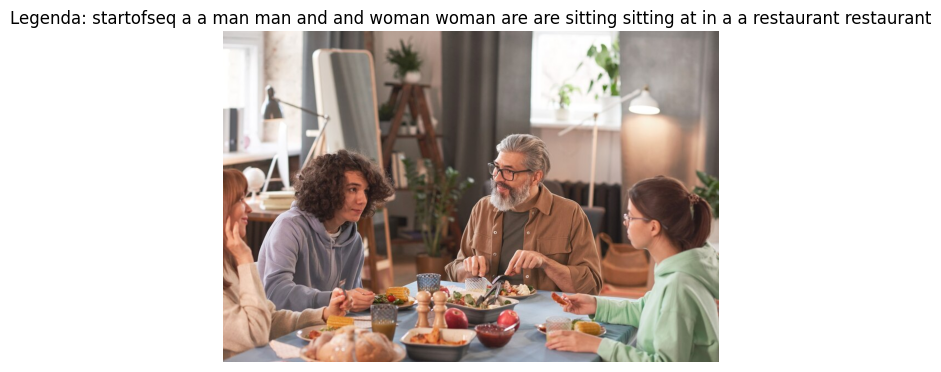

In [ ]:
import os
import pickle
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# Verificar se os arquivos existem
if not os.path.exists("vocab.pkl"):
    raise FileNotFoundError("O arquivo vocab.pkl não foi encontrado.")
if not os.path.exists("best_checkpoint_1.pth"):
    raise FileNotFoundError("O arquivo best_checkpoint_1.pth não foi encontrado.")

# Carregar o vocabulário
with open("vocab.pkl", "rb") as f:
    vocab = pickle.load(f)
#print("Vocabulário carregado com sucesso!")

# Carregar o modelo treinado
def load_model(checkpoint_path, embed_dim, hidden_dim, vocab_size, device):
    encoder = ResNetEncoder(embed_dim)
    decoder = DecoderLSTM(embed_dim, hidden_dim, vocab_size)
    model = ImageCaptioningModel(encoder, decoder).to(device)
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    return model

model = load_model("best_checkpoint_1.pth", EMBED_DIM, HIDDEN_DIM, len(vocab), DEVICE)
#print("Modelo carregado com sucesso!")

# Pré-processar a imagem
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

image_path = "/content/2.jpg"  # Caminho da imagem
image = Image.open(image_path).convert("RGB")
image_tensor = transform(image).unsqueeze(0).to(DEVICE)
#print("Imagem pré-processada com sucesso!")

# Gerar a legenda
def generate_caption(model, image, vocab, max_length=20):
    model.eval()
    with torch.no_grad():
        features = model.encoder(image)
        captions = [vocab.stoi["startofseq"]]

        for _ in range(max_length):
            captions_tensor = torch.tensor(captions).unsqueeze(0).to(DEVICE)
            output = model.decoder(features, captions_tensor)
            predicted = output.argmax(2)[:, -1].item()
            captions.append(predicted)
            if predicted == vocab.stoi["endofseq"]:
                break

    caption_words = [vocab.itos[idx] for idx in captions]
    return ' '.join(caption_words[1:-1])  # Remover <start> e <end>

caption = generate_caption(model, image_tensor, vocab)
print("Legenda gerada:", caption)

# Exibir a imagem e a legenda
plt.imshow(image)
plt.axis("off")  # Remover eixos
plt.title(f"Legenda: {caption}", fontsize=12)
plt.show()

Legenda gerada: a man and woman are sitting at in a restaurant


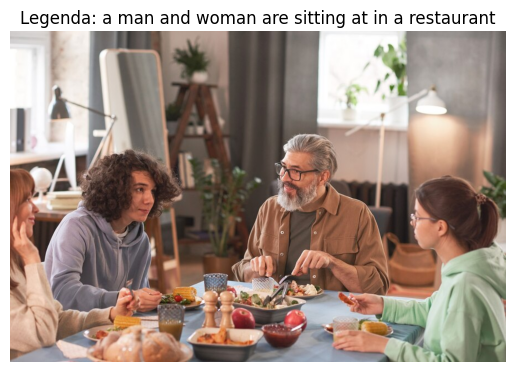

In [ ]:
import os
import pickle
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# Verificar se os arquivos existem
if not os.path.exists("vocab.pkl"):
    raise FileNotFoundError("O arquivo vocab.pkl não foi encontrado.")
if not os.path.exists("best_checkpoint_1.pth"):
    raise FileNotFoundError("O arquivo best_checkpoint_1.pth não foi encontrado.")

# Carregar o vocabulário
with open("vocab.pkl", "rb") as f:
    vocab = pickle.load(f)
#print("Vocabulário carregado com sucesso!")



# Pré-processar a imagem
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

image_path = "/content/2.jpg"  # Caminho da imagem
image = Image.open(image_path).convert("RGB")
image_tensor = transform(image).unsqueeze(0).to(DEVICE)
#print("Imagem pré-processada com sucesso!")

def generate_caption(model, image, vocab, max_length=20):
    model.eval()
    with torch.no_grad():
        features = model.encoder(image)
        captions = [vocab.stoi["startofseq"]]

        for _ in range(max_length):
            captions_tensor = torch.tensor(captions).unsqueeze(0).to(DEVICE)
            output = model.decoder(features, captions_tensor)
            predicted = output.argmax(2)[:, -1].item()
            captions.append(predicted)
            if predicted == vocab.stoi["endofseq"]:
                break

    # Converter índices para palavras
    caption_words = [vocab.itos[idx] for idx in captions]

    # Remover tokens especiais e duplicações consecutivas
    filtered_caption = []
    prev_word = None
    for word in caption_words:
        if word not in ["startofseq", "endofseq"] and word != prev_word:
            filtered_caption.append(word)
        prev_word = word

    return ' '.join(filtered_caption)


caption = generate_caption(model, image_tensor, vocab)
print("Legenda gerada:", caption)

# Exibir a imagem e a legenda
plt.imshow(image)
plt.axis("off")  # Remover eixos
plt.title(f"Legenda: {caption}", fontsize=12)
plt.show()

# Carregar Gradio

In [ ]:
!pip install wandb
!pip install torch torchvision gradio
!pip install --upgrade --force-reinstall nltk
!pip install datasets
!pip install optuna
!pip install wandb
!pip install kagglehub
!pip install transformers
#!pip install sentencepiece

  Using cached nltk-3.9.1-py3-none-any.whl.metadata (2.9 kB)
  Using cached click-8.1.8-py3-none-any.whl.metadata (2.3 kB)
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached regex-2024.11.6-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (40 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
Using cached nltk-3.9.1-py3-none-any.whl (1.5 MB)
Using cached regex-2024.11.6-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (792 kB)
Using cached click-8.1.8-py3-none-any.whl (98 kB)
Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.67.1
    Uninstalling tqdm-4.67.1:
      Successfully uninstalled tqdm-4.67.1
  Attempting uninstall: regex
    Found existing installation: regex 2024.11.6
    Uninstalling regex-2024.11.6:
      Successfully uninstalled regex-2024.11.6
  Attempting uninstall: joblib
    Found

In [ ]:
import os
import re
import csv
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import random
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pytz
import sklearn
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from torchvision.models import ResNet50_Weights
from collections import Counter

In [ ]:
from google.colab import drive

# 1. Montar o Google Drive
drive.mount('/content/drive')

In [ ]:
import pickle

# Carregar o vocabulário
with open("vocab.pkl", "rb") as f:
    vocab = pickle.load(f)

print("Vocabulário carregado com sucesso!")

In [ ]:
import os
import pickle
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import gradio as gr

# Verificar se os arquivos existem
if not os.path.exists("vocab.pkl"):
    raise FileNotFoundError("O arquivo vocab.pkl não foi encontrado.")
if not os.path.exists("best_checkpoint_1.pth"):
    raise FileNotFoundError("O arquivo best_checkpoint_1.pth não foi encontrado.")

# Carregar o vocabulário
with open("vocab.pkl", "rb") as f:
    vocab = pickle.load(f)
print("Vocabulário carregado com sucesso!")

# Carregar o modelo treinado
def load_model(checkpoint_path, embed_dim, hidden_dim, vocab_size, device):
    encoder = ResNetEncoder(embed_dim)
    decoder = DecoderLSTM(embed_dim, hidden_dim, vocab_size)
    model = ImageCaptioningModel(encoder, decoder).to(device)
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    return model
# Usar os melhores hiperparâmetros encontrados pelo Optuna
best_params = {
    'embed_dim': 320,
    'hidden_dim': 256,
    'learning_rate': 0.0016399457637235142,
    'batch_size': 32
}

EMBED_DIM = best_params['embed_dim']
HIDDEN_DIM = best_params['hidden_dim']
LEARNING_RATE = best_params['learning_rate']
BATCH_SIZE = best_params['batch_size']

# Carregar o modelo
model = load_model("best_checkpoint_1.pth", EMBED_DIM, HIDDEN_DIM, len(vocab), DEVICE)
print("Modelo carregado com sucesso!")

# Pré-processar a imagem
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Função para gerar legendas
def generate_caption(model, image, vocab, max_length=20):
    model.eval()
    with torch.no_grad():
        features = model.encoder(image)
        captions = [vocab.stoi["startofseq"]]

        for _ in range(max_length):
            captions_tensor = torch.tensor(captions).unsqueeze(0).to(DEVICE)
            output = model.decoder(features, captions_tensor)
            predicted = output.argmax(2)[:, -1].item()
            captions.append(predicted)
            if predicted == vocab.stoi["endofseq"]:
                break

    # Converter índices para palavras
    caption_words = [vocab.itos[idx] for idx in captions]

    # Remover tokens especiais e duplicações consecutivas
    filtered_caption = []
    prev_word = None
    for word in caption_words:
        if word not in ["startofseq", "endofseq"] and word != prev_word:
            filtered_caption.append(word)
        prev_word = word

    return ' '.join(filtered_caption)

# Função para integrar com Gradio
def gradio_interface(image):
    # Pré-processar a imagem
    image_tensor = transform(image).unsqueeze(0).to(DEVICE)

    # Gerar a legenda
    caption = generate_caption(model, image_tensor, vocab)

    # Retornar a imagem e a legenda
    return image, f"Legenda gerada: {caption}"

# Configurar a interface do Gradio
interface = gr.Interface(
    fn=gradio_interface,
    inputs=gr.Image(type="pil"),  # Entrada: imagem
    outputs=[gr.Image(type="pil"), gr.Textbox(label="Legenda Gerada")],  # Saída: imagem e legenda
    title="Geração de Legendas para Imagens",
    #description="Carregue uma imagem para gerar uma legenda usando um modelo treinado de descrição de imagens.",
)

# Executar a interface
interface.launch()

Vocabulário carregado com sucesso!


<ipython-input-30-03993c7a74c9>:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


Modelo carregado com sucesso!
Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://8b5b18e76c0fe2c35c.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
